# This notebook is used to evaluate trained model B

## Example: Raleigh

We now use Raleigh, which is the first as well as trained scenario for testing. Trained models should be evaluated in more scenario in the future

In [1]:
# we need to check if we are using the same conda env as training, which is modelA_sb3

import sys
print("sys.executable =", sys.executable)
print("python version =", sys.version)

sys.executable = /home/jhuang52/miniconda3/envs/modelB_env/bin/python
python version = 3.11.5 (main, Sep 11 2023, 13:54:46) [GCC 11.2.0]


## Goals
- Reload a trained Model B checkpoint (BenchMARL experiment)
- Rollout evaluation with controlled scenarios (optional)
- Save NPZ results for later visualization/analysis
- Quick sanity plots: success rates, distance curves, reached fraction


In [2]:
import os
from pathlib import Path

# ========= User-editable paths =========
PROJECT_ROOT = Path("/home/jhuang52/Projects/metaRL_merged").resolve()

# BenchMARL run directory (the run root that contains checkpoints/, .hydra/, wandb/, etc.)
RUN_DIR = Path(
    "/home/jhuang52/Projects/BenchMARL/benchmarl/outputs/2026-02-01/20-15-30/"
    "masac_raleigh_city_mlp__0711bfa5_26_02_01-20_15_30"
).resolve()

# ========= Derived paths (recommended: do NOT hardcode below) =========
EVAL_TOOLS_DIR = PROJECT_ROOT / "eval_tools" / "model_b"

# Buildings (scene) JSON: buildings-only file for collision/visualization
BUILDINGS_JSON = PROJECT_ROOT / "scenarios" / "raleigh_buildings.json"
USE_BUILDINGS = True  # set False if you don't want collision/overlay in plots

# Eval cases YAML: UAV/targets initial states (multiple cases)
EVAL_CASES_YAML = EVAL_TOOLS_DIR / "eval_modelB_cases.yaml"
USE_EVAL_CASES = True  # set False if you want pure random reset evaluation

# Output dir (keep under eval_tools/ to avoid polluting repo root)
OUT_DIR = PROJECT_ROOT / "eval_tools" / "model_b_eval"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ========= Resolve checkpoint =========
CKPT_DIR = RUN_DIR / "checkpoints"
ckpts = sorted(CKPT_DIR.glob("checkpoint_*.pt"))
if not ckpts:
    raise FileNotFoundError(f"No checkpoint_*.pt found under: {CKPT_DIR}")
CKPT_PATH = ckpts[-1]  # latest (e.g., checkpoint_60000.pt)

# ========= Environment flags =========
# Avoid wandb creating/resuming runs inside notebook reload/eval
os.environ.setdefault("WANDB_MODE", "disabled")  # or "offline"

# Add project root to python path so we can import eval_tools.*
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# ========= Prints / sanity =========
print("PROJECT_ROOT:", PROJECT_ROOT)
print("EVAL_TOOLS_DIR:", EVAL_TOOLS_DIR, "exists:", EVAL_TOOLS_DIR.exists())
print("RUN_DIR:", RUN_DIR, "exists:", RUN_DIR.exists())
print("CKPT_PATH:", CKPT_PATH, "exists:", CKPT_PATH.exists())
print("OUT_DIR:", OUT_DIR)

print("BUILDINGS_JSON:", BUILDINGS_JSON, "exists:", BUILDINGS_JSON.exists(), "USE_BUILDINGS:", USE_BUILDINGS)
print("EVAL_CASES_YAML:", EVAL_CASES_YAML, "exists:", EVAL_CASES_YAML.exists(), "USE_EVAL_CASES:", USE_EVAL_CASES)


PROJECT_ROOT: /home/jhuang52/Projects/metaRL_merged
EVAL_TOOLS_DIR: /home/jhuang52/Projects/metaRL_merged/eval_tools/model_b exists: True
RUN_DIR: /home/jhuang52/Projects/BenchMARL/benchmarl/outputs/2026-02-01/20-15-30/masac_raleigh_city_mlp__0711bfa5_26_02_01-20_15_30 exists: True
CKPT_PATH: /home/jhuang52/Projects/BenchMARL/benchmarl/outputs/2026-02-01/20-15-30/masac_raleigh_city_mlp__0711bfa5_26_02_01-20_15_30/checkpoints/checkpoint_60000.pt exists: True
OUT_DIR: /home/jhuang52/Projects/metaRL_merged/eval_tools/model_b_eval
BUILDINGS_JSON: /home/jhuang52/Projects/metaRL_merged/scenarios/raleigh_buildings.json exists: True USE_BUILDINGS: True
EVAL_CASES_YAML: /home/jhuang52/Projects/metaRL_merged/eval_tools/model_b/eval_modelB_cases.yaml exists: True USE_EVAL_CASES: True


In [10]:
from eval_tools.model_b.model_b_functions import (
    reload_experiment,
    load_buildings_json,
    load_eval_cases_yaml,
    load_eval_cases_yaml,
    select_eval_cases,
    rollout_and_collect,      # if your function name differs, change it
    get_positions_from_env,
    apply_eval_case_to_env,
    save_results_npz,
    load_results_npz,
    extract_episode_traj,     # optional, if you implemented
)

print("Imported model_b_functions successfully.")


Imported model_b_functions successfully.


In [4]:
experiment = reload_experiment(str(CKPT_PATH))
print("Reloaded experiment.")
print("Has policy:", hasattr(experiment, "policy"))
print("Has test_env:", hasattr(experiment, "test_env") and experiment.test_env is not None)
print("Env name:", getattr(experiment, "environment_name", None))
print("Task name:", getattr(experiment, "task_name", None))



Reloaded experiment with:

Algorithm: masac, Task: nav3d/raleigh_city

Loaded config:

experiment:
  sampling_device: cpu
  train_device: cpu
  buffer_device: cpu
  share_policy_params: true
  prefer_continuous_actions: true
  collect_with_grad: false
  parallel_collection: true
  gamma: 0.99
  lr: 5.0e-05
  adam_eps: 1.0e-06
  clip_grad_norm: true
  clip_grad_val: 5.0
  soft_target_update: true
  polyak_tau: 0.005
  hard_target_update_frequency: 5
  exploration_eps_init: 0.8
  exploration_eps_end: 0.01
  exploration_anneal_frames: null
  max_n_iters: 20
  max_n_frames: 60000
  on_policy_collected_frames_per_batch: 6000
  on_policy_n_envs_per_worker: 10
  on_policy_n_minibatch_iters: 45
  on_policy_minibatch_size: 400
  off_policy_collected_frames_per_batch: 6000
  off_policy_n_envs_per_worker: 10
  off_policy_n_optimizer_steps: 1000
  off_policy_train_batch_size: 128
  off_policy_memory_size: 1000000
  off_policy_init_random_frames: 0
  off_policy_use_prioritized_replay_buffer: false

/home/jhuang52/Projects/BenchMARL/benchmarl/environments/common.py:41: UserWarning: TaskConfig python dataclass not found, task is being loaded without type checks
  warnings.warn(
/home/jhuang52/Projects/BenchMARL/benchmarl/experiment/experiment.py:311: UserWarning: max_n_frames and max_n_iters have both been set. The experiment will terminate after 10 iterations (60000 frames).
  warnings.warn(
/home/jhuang52/miniconda3/envs/modelB_env/lib/python3.11/site-packages/torchrl/data/tensor_specs.py:6705: DeprecationWarning: The UnboundedContinuousTensorSpec has been deprecated and will be removed in v0.8. Please use Unbounded instead.
  warnings.warn(
/home/jhuang52/miniconda3/envs/modelB_env/lib/python3.11/site-packages/torchrl/data/tensor_specs.py:6705: DeprecationWarning: The CompositeSpec has been deprecated and will be removed in v0.8. Please use Composite instead.
  warnings.warn(
/home/jhuang52/miniconda3/envs/modelB_env/lib/python3.11/site-packages/torchrl/data/tensor_specs.py:6705

Reloaded experiment.
Has policy: True
Has test_env: True
Env name: nav3d
Task name: raleigh_city


In [5]:
# ----- 1) Load buildings (scene) -----
buildings = None
if USE_BUILDINGS:
    buildings = load_buildings_json(str(BUILDINGS_JSON))
    # buildings 可能是 list 或 dict，这里都做兼容打印
    if isinstance(buildings, list):
        print(f"[buildings] loaded list: {len(buildings)} buildings")
        # 尝试打印一个 building 的关键字段
        if len(buildings) > 0 and isinstance(buildings[0], dict):
            print("[buildings] sample keys:", list(buildings[0].keys())[:20])
    elif isinstance(buildings, dict):
        print(f"[buildings] loaded dict keys: {list(buildings.keys())[:30]}")
    else:
        print(f"[buildings] loaded type: {type(buildings)}")
else:
    print("[buildings] disabled")


# ----- 2) Load eval cases (UAV/targets init states) -----
cases_obj = None
eval_cases = None

if USE_EVAL_CASES:
    cases_obj = load_eval_cases_yaml(str(EVAL_CASES_YAML))
    meta = cases_obj.get("meta", {}) or {}
    cases = cases_obj["cases"]

    print(f"[cases] loaded: {len(cases)} cases")
    print("[cases] meta keys:", list(meta.keys()))

    # 打印前几个 case 的摘要
    print("[cases] first case ids:", [c.get("id") for c in cases[:10]])

    # ---- Choose which cases to evaluate ----
    # 你可以在这里填具体 case id；None 表示评估全部
    INCLUDE_CASE_IDS = None  # e.g. ["S1_open_near", "M1_near_buildings"]
    EXCLUDE_CASE_IDS = None  # e.g. ["H2_tight_corridor"]
    PATTERN = None           # e.g. "S" or "M1"
    LIMIT = None             # e.g. 3

    eval_cases = select_eval_cases(
        cases,
        include_ids=INCLUDE_CASE_IDS,
        exclude_ids=EXCLUDE_CASE_IDS,
        pattern=PATTERN,
        limit=LIMIT,
    )

    print(f"[cases] selected: {len(eval_cases)} cases")
    print("[cases] selected ids:", [c.get("id") for c in eval_cases])

    # 基本 shape 提示（只看第一个）
    if len(eval_cases) > 0:
        c0 = eval_cases[0]
        print("[cases] example id:", c0.get("id"))
        try:
            print("[cases] uav_pos len:", len(c0["uav_pos"]))
            print("[cases] targets len:", len(c0["targets"]))
        except Exception as e:
            print("[cases] shape print skipped:", e)

else:
    print("[cases] disabled (will use env random reset)")


[buildings] loaded dict keys: ['meta', 'buildings']
[cases] loaded: 2 cases
[cases] meta keys: ['version', 'name', 'coord_frame', 'units', 'scene_bounds', 'num_uavs', 'num_targets']
[cases] first case ids: ['S1_open_near', 'M1_near_buildings']
[cases] selected: 2 cases
[cases] selected ids: ['S1_open_near', 'M1_near_buildings']
[cases] example id: S1_open_near
[cases] uav_pos len: 5
[cases] targets len: 5


In [6]:
EPISODES_PER_CASE = 20
MAX_STEPS = 200

all_results = {}
for case in eval_cases:
    case_id = case["id"]
    results = rollout_and_collect(
        experiment=experiment,
        episodes=EPISODES_PER_CASE,
        max_steps=MAX_STEPS,
        case=case,
        buildings=buildings,              # 目前预留，可视化时用
        apply_to_all_envs=False,
        deterministic=True,
        log=print,
    )
    all_results[case_id] = results

print("Done:", list(all_results.keys()))


[apply_case] applied case id=S1_open_near env_idx=0 uavs=5 targets=5
[rollout] ep 1/20 return=-3825.758 len=200 case=S1_open_near
[apply_case] applied case id=S1_open_near env_idx=0 uavs=5 targets=5
[rollout] ep 2/20 return=-3764.510 len=200 case=S1_open_near
[apply_case] applied case id=S1_open_near env_idx=0 uavs=5 targets=5
[rollout] ep 3/20 return=-2998.027 len=200 case=S1_open_near
[apply_case] applied case id=S1_open_near env_idx=0 uavs=5 targets=5
[rollout] ep 4/20 return=-4393.923 len=200 case=S1_open_near
[apply_case] applied case id=S1_open_near env_idx=0 uavs=5 targets=5
[rollout] ep 5/20 return=-3527.392 len=200 case=S1_open_near
[apply_case] applied case id=S1_open_near env_idx=0 uavs=5 targets=5
[rollout] ep 6/20 return=-4042.066 len=200 case=S1_open_near
[apply_case] applied case id=S1_open_near env_idx=0 uavs=5 targets=5
[rollout] ep 7/20 return=-3169.785 len=200 case=S1_open_near
[apply_case] applied case id=S1_open_near env_idx=0 uavs=5 targets=5
[rollout] ep 8/20 ret

In [16]:
td0 = experiment.test_env.reset()
uav_now, tar_now = get_positions_from_env(experiment.test_env)
print("uav_now:", None if uav_now is None else uav_now.shape)
print("tar_now:", None if tar_now is None else tar_now.shape)

env = experiment.test_env
case = eval_cases[0]

apply_eval_case_to_env(env, case, apply_to_all_envs=False, log=print)
td = env.reset()

uav0, tar0 = get_positions_from_env(env)
print("uav0 shape:", None if uav0 is None else uav0.shape)
print("tar0 shape:", None if tar0 is None else tar0.shape)
print("uav0[0,0]:", None if uav0 is None else uav0[0,0])
print("tar0[0,0]:", None if tar0 is None else tar0[0,0])

def traj_has_positions(results, n_check=3):
    traj = results["traj"]
    n = min(len(traj), n_check)
    for i in range(n):
        u = traj[i]["uav_pos"]
        t = traj[i]["targets"]
        # 找到第一个非 None
        u_ok = any(x is not None for x in u)
        t_ok = any(x is not None for x in t)
        print(f"ep {i}: uav_pos_has_data={u_ok}, targets_has_data={t_ok}")

for case_id, res in all_results.items():
    print("\n===", case_id, "===")
    traj_has_positions(res, n_check=3)


uav_now: (10, 5, 3)
tar_now: (10, 5, 3)
[apply_case] applied case id=S1_open_near env_idx=0 uavs=5 targets=5
uav0 shape: (10, 5, 3)
tar0 shape: (10, 5, 3)
uav0[0,0]: [-800. -800.   50.]
tar0[0,0]: [-600. -600.   50.]

=== S1_open_near ===
ep 0: uav_pos_has_data=True, targets_has_data=True
ep 1: uav_pos_has_data=True, targets_has_data=True
ep 2: uav_pos_has_data=True, targets_has_data=True

=== M1_near_buildings ===
ep 0: uav_pos_has_data=True, targets_has_data=True
ep 1: uav_pos_has_data=True, targets_has_data=True
ep 2: uav_pos_has_data=True, targets_has_data=True


In [17]:
import numpy as np
import matplotlib.pyplot as plt

def _stack_steps(step_list):
    """
    step_list: list length S, each element is (B,N,3) numpy
    return: U shape (S,B,N,3)
    """
    arr = []
    for x in step_list:
        if x is None:
            arr.append(None)
        else:
            arr.append(np.asarray(x, dtype=float))
    # forward-fill None (保险)
    for i in range(len(arr)):
        if arr[i] is None:
            arr[i] = arr[i-1]
    return np.stack(arr, axis=0)

def get_episode_traj_arrays(all_results, case_id, episode_idx=0, env_idx=0):
    """
    Return:
      U: (S,N,3) uav trajectory for selected env_idx
      T: (S,N,3) targets (usually constant, but keep time axis)
    """
    ep = all_results[case_id]["traj"][episode_idx]
    U4 = _stack_steps(ep["uav_pos"])      # (S,B,N,3)
    T4 = _stack_steps(ep["targets"])     # (S,B,N,3)
    U = U4[:, env_idx, :, :]             # (S,N,3)
    T = T4[:, env_idx, :, :]             # (S,N,3)
    return U, T

def print_episode_basic(all_results, case_id, episode_idx=0):
    ep = all_results[case_id]["traj"][episode_idx]
    U4 = np.asarray(ep["uav_pos"][0])
    print("uav_pos[0] shape:", U4.shape)
    print("targets[0] shape:", np.asarray(ep["targets"][0]).shape)


In [18]:
def get_building_polys_2d(buildings_obj, max_buildings=None):
    """
    buildings_obj: either dict with key 'buildings' or list of dict
    returns list of polys: each poly is (M,2) ndarray, closed or not都行
    """
    if buildings_obj is None:
        return []

    b_list = buildings_obj["buildings"] if isinstance(buildings_obj, dict) and "buildings" in buildings_obj else buildings_obj
    if not isinstance(b_list, list):
        return []

    polys = []
    for i, b in enumerate(b_list):
        if max_buildings is not None and i >= max_buildings:
            break
        if not isinstance(b, dict):
            continue

        fp = b.get("footprint", None)
        if isinstance(fp, list) and len(fp) >= 3:
            fp_xy = np.asarray(fp, dtype=float)
            if fp_xy.ndim == 2 and fp_xy.shape[1] >= 2 and np.isfinite(fp_xy).all():
                polys.append(fp_xy[:, :2])
                continue

        # fallback aabb rectangle
        if all(k in b for k in ["xmin","xmax","ymin","ymax"]):
            xmin, xmax = float(b["xmin"]), float(b["xmax"])
            ymin, ymax = float(b["ymin"]), float(b["ymax"])
            rect = np.asarray([[xmin,ymin],[xmax,ymin],[xmax,ymax],[xmin,ymax],[xmin,ymin]], dtype=float)
            polys.append(rect)

    return polys


In [19]:
def plot_episode_2d(all_results, case_id, episode_idx=0, env_idx=0, buildings_obj=None,
                    uav_indices=None, show_targets=True, title=None, max_buildings=3000):
    U, T = get_episode_traj_arrays(all_results, case_id, episode_idx, env_idx)
    S, N, _ = U.shape
    if uav_indices is None:
        uav_indices = list(range(N))

    polys = get_building_polys_2d(buildings_obj, max_buildings=max_buildings)

    plt.figure(figsize=(8, 8))

    # buildings
    for poly in polys:
        plt.plot(poly[:,0], poly[:,1], linewidth=0.4)

    # targets (take first frame)
    if show_targets:
        plt.scatter(T[0,:,0], T[0,:,1], marker="x", s=80)

    # UAV paths
    for i in uav_indices:
        plt.plot(U[:,i,0], U[:,i,1], linewidth=1.2)
        plt.scatter(U[0,i,0], U[0,i,1], marker="o", s=50)     # start
        plt.scatter(U[-1,i,0], U[-1,i,1], marker="s", s=50)   # end

    plt.axis("equal")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title or f"2D Trajectory | case={case_id} ep={episode_idx} env={env_idx} | steps={S}")
    plt.show()


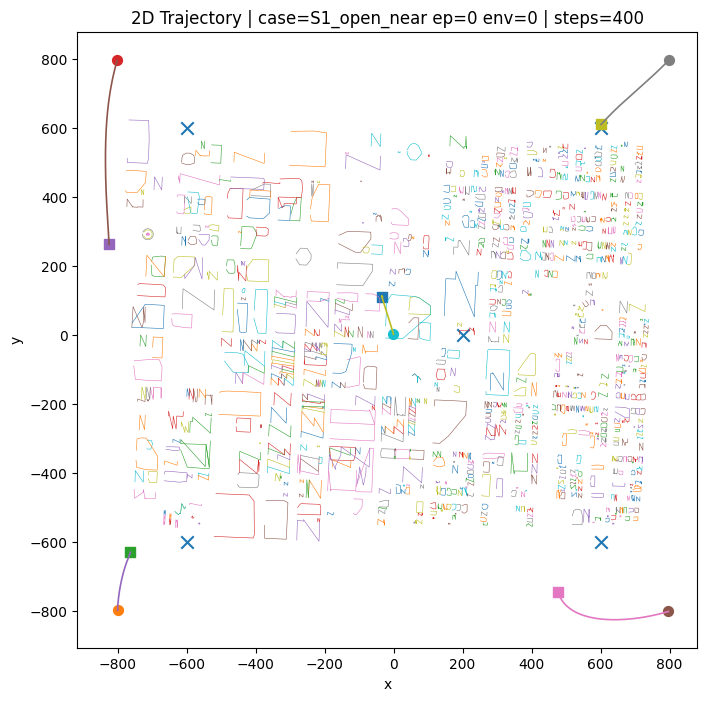

In [20]:
plot_episode_2d(all_results, "S1_open_near", episode_idx=0, env_idx=0, buildings_obj=buildings)


In [21]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def plot_episode_3d(all_results, case_id, episode_idx=0, env_idx=0, uav_indices=None, title=None):
    U, T = get_episode_traj_arrays(all_results, case_id, episode_idx, env_idx)
    S, N, _ = U.shape
    if uav_indices is None:
        uav_indices = list(range(N))

    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection="3d")

    # targets
    ax.scatter(T[0,:,0], T[0,:,1], T[0,:,2], marker="x", s=80)

    # UAV paths
    for i in uav_indices:
        ax.plot(U[:,i,0], U[:,i,1], U[:,i,2])
        ax.scatter(U[0,i,0], U[0,i,1], U[0,i,2], marker="o", s=40)   # start
        ax.scatter(U[-1,i,0], U[-1,i,1], U[-1,i,2], marker="s", s=40) # end

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_title(title or f"3D Trajectory | case={case_id} ep={episode_idx} env={env_idx} | steps={S}")
    plt.show()


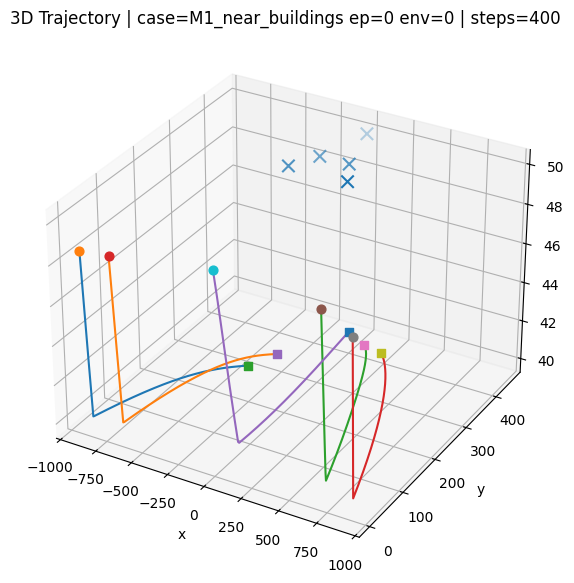

In [22]:
plot_episode_3d(all_results, "M1_near_buildings", episode_idx=0, env_idx=0)


In [23]:
def plot_episode_2d_with_reach(all_results, case_id, episode_idx=0, env_idx=0, buildings_obj=None,
                              reach_radius=15.0, one_to_one=True, max_buildings=3000):
    U, T = get_episode_traj_arrays(all_results, case_id, episode_idx, env_idx)
    S, N, _ = U.shape

    polys = get_building_polys_2d(buildings_obj, max_buildings=max_buildings)

    plt.figure(figsize=(8, 8))
    for poly in polys:
        plt.plot(poly[:,0], poly[:,1], linewidth=0.4)

    plt.scatter(T[0,:,0], T[0,:,1], marker="x", s=80)

    # compute dist
    if one_to_one:
        dist = np.linalg.norm(U - T, axis=-1)  # (S,N)
    else:
        dist = np.linalg.norm(U[:,:,None,:] - T[:,None,:,:], axis=-1).min(axis=2)

    for i in range(N):
        plt.plot(U[:,i,0], U[:,i,1], linewidth=1.2)
        plt.scatter(U[0,i,0], U[0,i,1], marker="o", s=50)
        plt.scatter(U[-1,i,0], U[-1,i,1], marker="s", s=50)

        hit = np.where(dist[:, i] <= reach_radius)[0]
        if len(hit) > 0:
            k = hit[0]
            plt.scatter(U[k,i,0], U[k,i,1], marker="*", s=120)  # reach marker

    plt.axis("equal")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"2D + Reach | case={case_id} ep={episode_idx} env={env_idx} r={reach_radius}")
    plt.show()


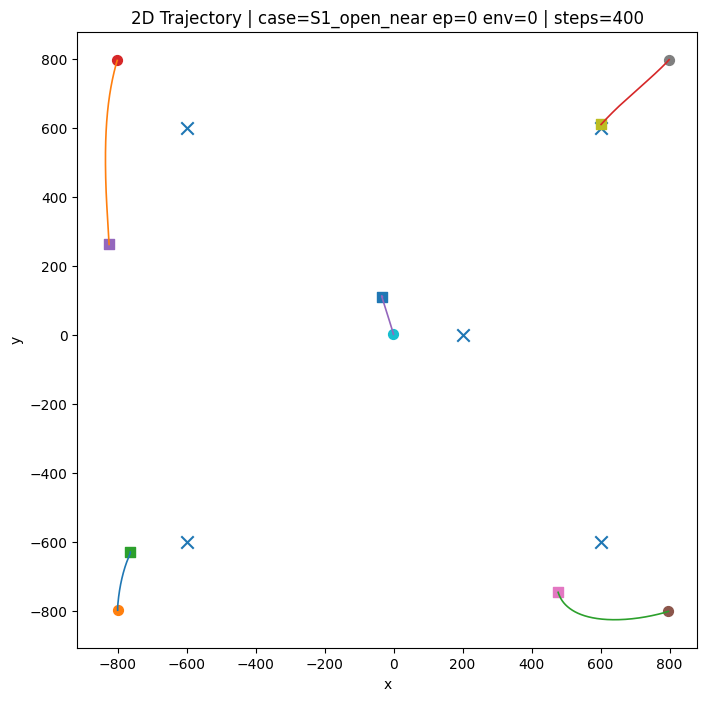

In [24]:
plot_episode_2d(all_results, "S1_open_near", episode_idx=0, env_idx=0, buildings_obj=None)


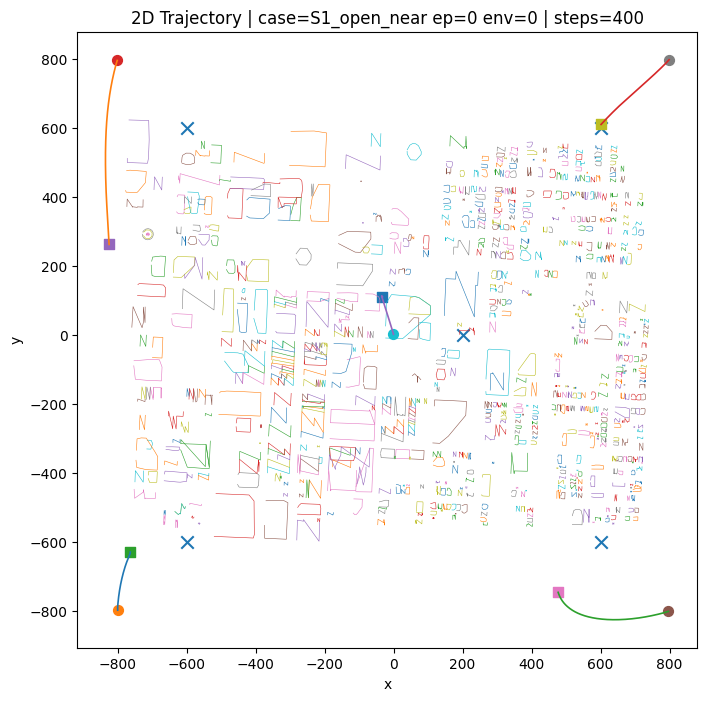

In [25]:
plot_episode_2d(all_results, "S1_open_near", episode_idx=0, env_idx=0, buildings_obj=buildings, max_buildings=800)


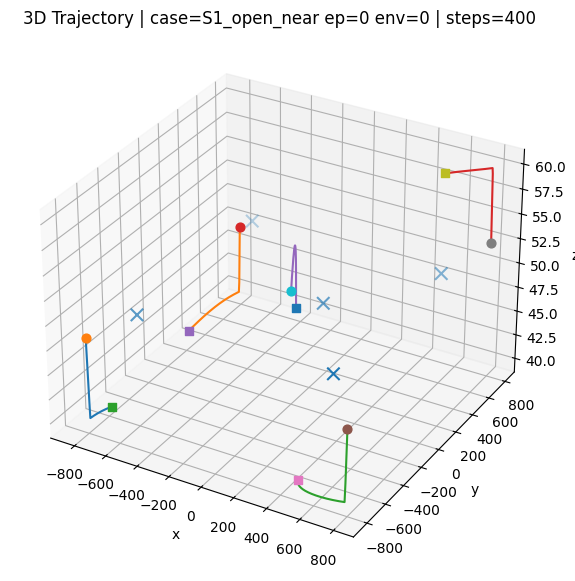

In [26]:
plot_episode_3d(all_results, "S1_open_near", episode_idx=0, env_idx=0)


In [ ]:
import time

timestamp = time.strftime("%Y%m%d_%H%M%S")
out_npz = OUT_DIR / f"nav3d_eval_modelB_{timestamp}.npz"

save_results_npz(results, str(out_npz))
print("Saved:", out_npz)


In [ ]:
results2 = load_results_npz(str(out_npz))
print("Reloaded NPZ keys:", sorted(results2.keys()))
print("num_envs:", results2.get("num_envs"))
print("success_radius:", results2.get("success_radius"))
